In [1]:
#%load_ext sympyprinting
%matplotlib inline
from sympy import init_printing
init_printing()
import time
# import the PagodaFunction class and additional helpers for plotting
from PagodaFunction import PagodaFunction as gp
from Plotting import plotHierarchical2d, evaluateSparseGrid, printSparseGrid, plotCombi2d

In [2]:
def parabola(xvec):
    '''The parabola test function in multiple dimensions'''
    result = 1.0
    for x in xvec:
        result *= 4.0*x*(1.0-x)
    return result
        
def applyRefinementCriterion(sg, dim, criterion, func):
    '''
    Applies the criterion to the leaves of the sparse grid.
     
    Calls the "apply" member for each leaf of the grid,
    then finishes calling the "finalize" member passing the
    grid and the approximated function as arguments.
    We'll also use it to build our sparse grid.
    '''
    # iterate over all grid points
    for (lKey,iKey) in sg:
        
        # Get the level vector and index vector of this grid point
        lvec, ivec = list(lKey), list(iKey)
        
        # Determine if this is a Leaf grid point by checking if it has exactly 2*d children.
        # Missing any child will make it a Leaf!
        isLeaf = False
        for d in range(dim):
            # original level,index values
            l_d = lvec[d]
            i_d = ivec[d]
            # Left child
            lvec[d] = l_d + 1
            ivec[d] = i_d*2 - 1
            leftChildKey = (tuple(lvec), tuple(ivec))
            # Right child
            ivec[d] = i_d*2 + 1
            rightChildKey = (tuple(lvec), tuple(ivec))
            # restore values for next dimension iteration
            lvec[d] = l_d  
            ivec[d] = i_d
            
            if (leftChild not in sg or rightChild not in sg):
                isLeaf = True
                break # break d-loop only
            
        # Only if this is a Leaf, we can refine it
        if isLeaf:
            criterion.apply(sg[key])
            
    criterion.finalize(sg, func)

### (i) ###
Implement the refinement criterion <tt>MinLevelCriterion</tt> that adds all points up to a specified
level to a given grid.<br/>
<b>Hint:</b> In your grid traversal, try to avoid multiple visits to the same grid points.


In [3]:
class MinLevelCriterion(object):
    '''Criterion adding all missing points up to a certain level.'''
    def __init__(self, dim, minLevel):
        self.dim = dim
        self.minLevel = minLevel  # the overall level we want our sparse grid to have
    def apply(self, af):
        pass # work is done in finalize
    def finalize(self, sg, func):
        '''Inserts the grid points recursively'''
        def insertRecursively(minD, l, lvec, ivec, xvec):
            
            # minD: (1, 2, ..., minD, minD+1, ..., d) 
            #     All dimensions that is < minD is not allowed to be modified.
            #     minD and minD+ dimensions are allowed to be modified. 
            #     For the purpose of visiting each grid point exactly once.
            
            # l:    (integer) level of the grid point to be added
            # lvec: (list) level vector of the grid point to be added, [l1, l2, ..., ld]
            # ivec: (list) index vector of the grid point (list),      [i1, i2, ..., id]
            # xvec: (list) coordinate vector of the grid point,        [x1, x2, ..., xd]
            
            '''
            Local recursive helper function for grid traversal.

            Use lvec and ivec (mutable lists) to identify the current point.
            Insert it if it does not exist, descend recursively if not
            on level minLevel. minD helps to ensure to not pay any point 
            multiple visits.
            '''
            
            # Construct Key of the grid point to be added
            key = (tuple(lvec), tuple(ivec))
            
            # If this point does not exist, insert it to sg
            if not key in sg:   
                sg[key] = gp(self.dim, lvec, ivec, func(xvec))

            # If this grid point has not reached the desired overall level (minLevel), 
            # we will try to add its children on each dimension
            if (l < self.minLevel):
                
                # Touch each grid point once!!
                for d in range(minD, self.dim):
                    # original values
                    x_d = xvec[d]
                    l_d = lvec[d]
                    i_d = ivec[d]
                    h_d = 1.0 / 2**(l_d+1) # this is mesh size for the child level
                    # insert left child
                    lvec[d] = l_d+1
                    ivec[d] = i_d*2 - 1
                    xvec[d] = x_d - h_d
                    insertRecursively(d, l+1, lvec, ivec, xvec)
                    # insert right child
                    ivec[d] = i_d*2 + 1
                    xvec[d] = x_d + h_d
                    insertRecursively(d, l+1, lvec, ivec, xvec)
                    # restore original values for next dim iteration
                    lvec[d] = l_d
                    ivec[d] = i_d
                    xvec[d] = x_d                    
        
        '''Issue top level call of the recursive function'''
        l = 1 
        lvec = [1,]*self.dim
        ivec = [1,]*self.dim
        xvec = [0.5,]*self.dim
        insertRecursively(0, l, lvec, ivec, xvec)

### (ii) ###
Implement the function <tt>hierarchize</tt> efficiently using a recursive approach.<br/>
<b>Hint:</b> The underlying traversal algorithm can be implemented similar to the one above.


In [4]:
def hierarchize(sg, dim):
    '''Recursive hierarchization function.'''
    def hierarchize1d(workDim, lvec, ivec, f_l, f_r):
        '''Recursive 1-D hierarchization to (lvec,ivec) in dimension workDim.'''
        key = (tuple(lvec), tuple(ivec))
        if not key in sg:
            return False
        p = sg[key]
        f_m = p.getSurplus() # surplus was first initialized with function value
        
        # original level, index values on workDim dimension
        l_w = lvec[workDim]
        i_w = ivec[workDim]
        # hierarhize left child
        lvec[workDim] = l_w+1                
        ivec[workDim] = 2*i_w - 1 
        hierarchize1d(workDim, lvec, ivec, f_l, f_m) 
        # hierarhize right child
        ivec[workDim] = 2*i_w + 1 
        hierarchize1d(workDim, lvec, ivec, f_m, f_r)
        # restore values for next dim iteration
        lvec[workDim] = l_w
        ivec[workDim] = i_w
        p.setSurplus(f_m - 0.5*(f_l+f_r))  # Actual hierarchization step: hierarchize self
        return True

    def traverseRecursively(workDim, minD, lvec, ivec):
        # workDim: is the dimension on which we do hierarchization
        
        # minD: is the minimum dimension on which we access children. That is, we access children 
        #       on all dimensions ranging from minD to dim-1 
        
        # lvec, ivec: together defines the grid point on which we want to apply 
        #             the recursive hierarchization algorithm
        
        '''
        Local recursive helper function for traversal of the "main axis" w.r.t. workDim.

        Use the same approach as in MinLevelCriterion.finalize to traverse only the main
        axis of the grid, i.e. all points with coordinate x_workDim=0.5
        Hint: Don't descend into workDim, as hierarchize1d will do that.
        '''
        key = (tuple(lvec), tuple(ivec))
        # apply 1d hierarchization!
        if not hierarchize1d(workDim, lvec, ivec, 0.0, 0.0):
            return

        # touch every child once
        for d in range(minD, dim):
            if d != workDim:
                # original values
                l_d = lvec[d]
                i_d = ivec[d]
                # left child
                lvec[d] = l_d + 1
                ivec[d] = 2*i_d - 1
                traverseRecursively(workDim, d, lvec, ivec)
                # right child
                ivec[d] = 2*i_d + 1
                traverseRecursively(workDim, d, lvec, ivec)
                # restore values
                lvec[d] = l_d
                ivec[d] = i_d
    
    # apply the 1-D hierarchization scheme for all dimensions, one after another
    lvec, ivec = [1,]*dim, [1,] * dim
    for d in range(dim):
        traverseRecursively(d, 0, lvec, ivec)

In [15]:
'''Main'''
# Funcion to interpolate using the sparse grid
func = parabola

# A dictionary(map) that contains all sparse grid points
# Dictionary: {Key1:Value1, Key2:Value2, ...}
# Key = ((l1,l2,...,ld),(i1, i2,...,id))
# Value = PagodaFunction object
sg = {}

# Dimensionality of the problem
dim = 2

# Minimum Overall level of the Sparse grid
minLevel = 4

# Create the sparse grid using MinLevelCriterion
applyRefinementCriterion(sg, dim, MinLevelCriterion(dim, minLevel), func)

# plot
print("Created sparse grid of level ", minLevel, ", with ", len(sg), " grid points.")
printSparseGrid(sg)


Created sparse grid of level  4 , with  49  grid points.
((1, 1), (1, 1)) : u_h( [0.5, 0.5] )= 1.0
((2, 1), (1, 1)) : u_h( [0.25, 0.5] )= 0.75
((3, 1), (1, 1)) : u_h( [0.125, 0.5] )= 0.4375
((4, 1), (1, 1)) : u_h( [0.0625, 0.5] )= 0.234375
((4, 1), (3, 1)) : u_h( [0.1875, 0.5] )= 0.609375
((3, 2), (1, 1)) : u_h( [0.125, 0.25] )= 0.328125
((3, 2), (1, 3)) : u_h( [0.125, 0.75] )= 0.328125
((3, 1), (3, 1)) : u_h( [0.375, 0.5] )= 0.9375
((4, 1), (5, 1)) : u_h( [0.3125, 0.5] )= 0.859375
((4, 1), (7, 1)) : u_h( [0.4375, 0.5] )= 0.984375
((3, 2), (3, 1)) : u_h( [0.375, 0.25] )= 0.703125
((3, 2), (3, 3)) : u_h( [0.375, 0.75] )= 0.703125
((2, 2), (1, 1)) : u_h( [0.25, 0.25] )= 0.5625
((2, 3), (1, 1)) : u_h( [0.25, 0.125] )= 0.328125
((2, 3), (1, 3)) : u_h( [0.25, 0.375] )= 0.703125
((2, 2), (1, 3)) : u_h( [0.25, 0.75] )= 0.5625
((2, 3), (1, 5)) : u_h( [0.25, 0.625] )= 0.703125
((2, 3), (1, 7)) : u_h( [0.25, 0.875] )= 0.328125
((2, 1), (3, 1)) : u_h( [0.75, 0.5] )= 0.75
((3, 1), (5, 1)) : u_h( [

In [16]:
tic = time.time()
hierarchize(sg, dim)
toc = time.time()
print("Hierarchiz",dim,"dimensional sparse grid in",toc-tic,"seconds")
printSparseGrid(sg)

Hierarchiz 2 dimensional sparse grid in 0.0005869865417480469 seconds
((1, 1), (1, 1)) : u_h( [0.5, 0.5] )= 1.0
((2, 1), (1, 1)) : u_h( [0.25, 0.5] )= 0.25
((3, 1), (1, 1)) : u_h( [0.125, 0.5] )= 0.0625
((4, 1), (1, 1)) : u_h( [0.0625, 0.5] )= 0.015625
((4, 1), (3, 1)) : u_h( [0.1875, 0.5] )= 0.015625
((3, 2), (1, 1)) : u_h( [0.125, 0.25] )= 0.015625
((3, 2), (1, 3)) : u_h( [0.125, 0.75] )= 0.015625
((3, 1), (3, 1)) : u_h( [0.375, 0.5] )= 0.0625
((4, 1), (5, 1)) : u_h( [0.3125, 0.5] )= 0.015625
((4, 1), (7, 1)) : u_h( [0.4375, 0.5] )= 0.015625
((3, 2), (3, 1)) : u_h( [0.375, 0.25] )= 0.015625
((3, 2), (3, 3)) : u_h( [0.375, 0.75] )= 0.015625
((2, 2), (1, 1)) : u_h( [0.25, 0.25] )= 0.0625
((2, 3), (1, 1)) : u_h( [0.25, 0.125] )= 0.015625
((2, 3), (1, 3)) : u_h( [0.25, 0.375] )= 0.015625
((2, 2), (1, 3)) : u_h( [0.25, 0.75] )= 0.0625
((2, 3), (1, 5)) : u_h( [0.25, 0.625] )= 0.015625
((2, 3), (1, 7)) : u_h( [0.25, 0.875] )= 0.015625
((2, 1), (3, 1)) : u_h( [0.75, 0.5] )= 0.25
((3, 1), (5,

In [17]:
tic = time.time()
for key in sg:
    x = sg[key].computeCoordinate()
    print(key, x, evaluateSparseGrid(sg, x), func(x))
toc = time.time()
print("Evaluation of sparse grid in", toc-tic, "seconds")

((1, 1), (1, 1)) [0.5, 0.5] 1.0 1.0
((2, 1), (1, 1)) [0.25, 0.5] 0.75 0.75
((3, 1), (1, 1)) [0.125, 0.5] 0.4375 0.4375
((4, 1), (1, 1)) [0.0625, 0.5] 0.234375 0.234375
((4, 1), (3, 1)) [0.1875, 0.5] 0.609375 0.609375
((3, 2), (1, 1)) [0.125, 0.25] 0.328125 0.328125
((3, 2), (1, 3)) [0.125, 0.75] 0.328125 0.328125
((3, 1), (3, 1)) [0.375, 0.5] 0.9375 0.9375
((4, 1), (5, 1)) [0.3125, 0.5] 0.859375 0.859375
((4, 1), (7, 1)) [0.4375, 0.5] 0.984375 0.984375
((3, 2), (3, 1)) [0.375, 0.25] 0.703125 0.703125
((3, 2), (3, 3)) [0.375, 0.75] 0.703125 0.703125
((2, 2), (1, 1)) [0.25, 0.25] 0.5625 0.5625
((2, 3), (1, 1)) [0.25, 0.125] 0.328125 0.328125
((2, 3), (1, 3)) [0.25, 0.375] 0.703125 0.703125
((2, 2), (1, 3)) [0.25, 0.75] 0.5625 0.5625
((2, 3), (1, 5)) [0.25, 0.625] 0.703125 0.703125
((2, 3), (1, 7)) [0.25, 0.875] 0.328125 0.328125
((2, 1), (3, 1)) [0.75, 0.5] 0.75 0.75
((3, 1), (5, 1)) [0.625, 0.5] 0.9375 0.9375
((4, 1), (9, 1)) [0.5625, 0.5] 0.984375 0.984375
((4, 1), (11, 1)) [0.6875, 0.

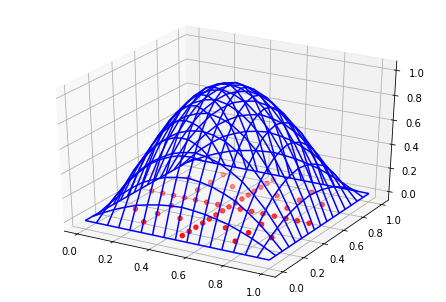

Plotting the sparse grid took 0.1377856731414795 seconds


In [18]:
tic = time.time()
plotHierarchical2d(sg, showGrid=True, minLevel=minLevel, azimuth=None, elevation=None)
toc = time.time()
print("Plotting the sparse grid took", toc-tic, "seconds")

# Exercise 3: One-dimensional Sparse Grids---An Adaptiave Implementation #

In [9]:
# import classes
from AnsatzFunction import AnsatzFunction as gp1d
from Plotting import plotHierarchical1d, plotSG1d

We want to use an adaptiave version of Archimedes' approach to approximate the integral $F(f,a,b) = \int_a^b f(x) \; dx$ of a function $f: \mathbb{R} \rightarrow \mathbb{R}$ or to approximate the function $f$ itself.<br/>
For the one-dimensional case we want to formalize this approach and generalize it in the following ways:

* Let $\phi(x)$ be the mother of all hat functions with

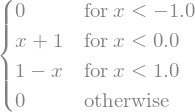

In [10]:
gp1d(0,0).getPhi()

* The data structure used to store the hierarchical coefficients is now called <i>Sparse Grid</i>.
* A sparse grid is defined by a particular set of interpolation points $x_{l,i}$ and associated ansatz functions $\phi_{l,i}(x)$ with
$$\phi_{l,i}(x) = \phi ( \; 2^l \cdot \left(x - i \cdot \frac{1}{2^l}  \right)\; ) =  \phi (2^l \cdot x - i ), \ l \in \mathbb{N}^{+}, 1 \leq i \leq 2^l - 1, i \mbox{ odd}$$
* Archimedes' approach from the lecture corresponds to a <i>regular</i> sparse grid.
* To improve the quality of approximation for arbitrary functions $f$ we introduce spatial adaptivity.

Import and use the class <tt>AnsatzFunction</tt> and look at the comments in the provided code snippets for some more details.<br/>
Use it to construct a one-dimensional sparse grid structure, which stores its grid points (resp. ansatz functions of type <tt>AnsatzFunction</tt> in a hash map.


In [11]:
# the function we want to approximate
def parabola(x):
    return 4*x*(1-x)

def asymmetric(x):
    return 8*(-16*x**4 + 40*x**3 -35*x**2 + 11*x)/9

func = parabola

def printSparseGrid(sg):
    for af in sg.values():
        x = af.computeCoordinate()
        print(af.getKey(), ": f(%f)=%f\tu(%f)=%f" % (x, af.getFunctionValue(), x, af.getSurplus()))

def evaluateSparseGrid(sg, x):
    '''Evaluates a given sparse grid at given point x'''
    return sum(map(lambda ansatz: ansatz(x), sg.values()))


def applyRefinementCriterion(sg, criterion, func):
    '''
    Applies the criterion to the leaves of the sparse grid.
     
    Calls the "apply" member for each leaf of the grid,
    then finishes calling the "finalize" member passing the
    grid and the approximated function as arguments.
    We'll also use it to build our sparse grid.
    '''
    # iterate over leaves only
    for key in sg:
        l = key[0]
        i = key[1]
        
        leftChild  = (l+1, 2*i-1)
        rightChild = (l+1, 2*i+1)
        
        if not (leftChild in sg and rightChild in sg):
            criterion.apply(sg[key])
    criterion.finalize(sg, func)

We start by creating an empty sparse grid.

In [12]:
sg = {}

We implement a <i>refinement criterion</i> that rather works as a grid generator and fills the sparse grid with points up to a given level.<br/>
The <i>apply</i> member does not really need to do anything. <i>finalize</i> then inserts all missing points up to level <i>minLevel</i>.

In [13]:
class MinLevelCriterion(object):
    '''Criterion adding all missing points up to a certain level.'''
    def __init__(self, minLevel):
        self.minLevel = minLevel
    def apply(self, af):
        pass
    def finalize(self, sg, func):
        for l in range(1, self.minLevel+1):
            for i in range(1, 2**l, 2):
                if not (l,i) in sg:
                    x = float(i)/2**l
                    f_x = func(x)
                    sg[(l,i)] = gp1d(l, i, f_x, f_x)

In [14]:
# fill the sparse grid
applyRefinementCriterion(sg, MinLevelCriterion(3), func)
printSparseGrid(sg)

(1, 1) : f(0.500000)=1.000000	u(0.500000)=1.000000
(2, 1) : f(0.250000)=0.750000	u(0.250000)=0.750000
(2, 3) : f(0.750000)=0.750000	u(0.750000)=0.750000
(3, 1) : f(0.125000)=0.437500	u(0.125000)=0.437500
(3, 3) : f(0.375000)=0.937500	u(0.375000)=0.937500
(3, 5) : f(0.625000)=0.937500	u(0.625000)=0.937500
(3, 7) : f(0.875000)=0.437500	u(0.875000)=0.437500


We implement the hierarchization method.
Try to only use the surpluses stored with the ansatz functions, not the function values.<br/>
<b>Hint:</b> In Python functions can be defined in every scope. You could make use of this feature and define and call to a recursive sub-function inside <i>hierarchize</i>.

In [15]:
def hierarchize(sg):
    '''Recursive hierarchization function.'''
    def rec(l, i, f_l, f_r):
        if (l,i) in sg:
            af = sg[(l,i)]
            f_m = af.getSurplus()
            rec(l+1, 2*i-1, f_l, f_m)
            rec(l+1, 2*i+1, f_m, f_r)
            af.setSurplus(f_m - 0.5*(f_l+f_r))
    rec(1, 1, 0.0, 0.0)

In [16]:
# apply hierarchization
hierarchize(sg)
printSparseGrid(sg)

(1, 1) : f(0.500000)=1.000000	u(0.500000)=1.000000
(2, 1) : f(0.250000)=0.750000	u(0.250000)=0.250000
(2, 3) : f(0.750000)=0.750000	u(0.750000)=0.250000
(3, 1) : f(0.125000)=0.437500	u(0.125000)=0.062500
(3, 3) : f(0.375000)=0.937500	u(0.375000)=0.062500
(3, 5) : f(0.625000)=0.937500	u(0.625000)=0.062500
(3, 7) : f(0.875000)=0.437500	u(0.875000)=0.062500


Define a more complex refinement criterion looking for and refining surpluses which are larger than a given $\varepsilon$.<br/>
<b>Hint:</b> This criterion can only be applied to a hierarchized grid. Remember this when ensuring a consistent state during the insertion of new grid points.

In [23]:
class EpsilonCriterion(object):
    '''Criterion refining points with large surpluses.'''
    
    # Initialize object with refinement threshold, and empty refinement list (contains grid points to refine)
    def __init__(self, eps):
        self.eps = eps
        self.toRefine = []
        
    # Find all grid points that satisfy the refinement criterion, i.e., surplus > threshold,
    # and put them in the refinement list
    def apply(self, sg):
        #TODO: Check
        #for af in sg.values():
        if abs(sg.getSurplus()) > self.eps:
            self.toRefine.append(sg.getKey())
    
    # Insert children for every grid point that is in the refinement list
    def finalize(self, sg, func):
        for (l,i) in self.toRefine:
            # left child
            childKey = tuple([l+1,2*i-1])
            if childKey not in sg:  # insert only if child not yet exists
                p = gp1d(l+1, 2*i-1)
                x = p.computeCoordinate()
                f_x = func(x)
                p.setFunctionValue(f_x)
                p.setSurplus(f_x - evaluateSparseGrid(sg, x))
                sg[childKey] = p
            # right child
            childKey = tuple([l+1,2*i+1])
            if childKey not in sg:  # insert only if child not yet exists
                p = gp1d(l+1, 2*i+1)
                x = p.computeCoordinate()
                f_x = func(x)
                p.setFunctionValue(f_x)
                p.setSurplus(f_x - evaluateSparseGrid(sg, x))
                sg[childKey] = p

In [24]:
# apply the criterion
applyRefinementCriterion(sg, EpsilonCriterion(0.06), func)
printSparseGrid(sg)

(1, 1) : f(0.500000)=1.000000	u(0.500000)=1.000000
(2, 1) : f(0.250000)=0.750000	u(0.250000)=0.250000
(2, 3) : f(0.750000)=0.750000	u(0.750000)=0.250000
(3, 1) : f(0.125000)=0.437500	u(0.125000)=0.062500
(3, 3) : f(0.375000)=0.937500	u(0.375000)=0.062500
(3, 5) : f(0.625000)=0.937500	u(0.625000)=0.062500
(3, 7) : f(0.875000)=0.437500	u(0.875000)=0.062500
(4, 1) : f(0.062500)=0.234375	u(0.062500)=0.015625
(4, 3) : f(0.187500)=0.609375	u(0.187500)=0.015625
(4, 5) : f(0.312500)=0.859375	u(0.312500)=0.015625
(4, 7) : f(0.437500)=0.984375	u(0.437500)=0.015625
(4, 9) : f(0.562500)=0.984375	u(0.562500)=0.015625
(4, 11) : f(0.687500)=0.859375	u(0.687500)=0.015625
(4, 13) : f(0.812500)=0.609375	u(0.812500)=0.015625
(4, 15) : f(0.937500)=0.234375	u(0.937500)=0.015625


Finally, have a look at the sparse grid.

Basis functions with surpluses on each level


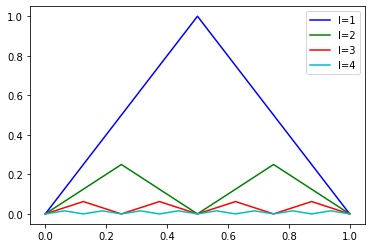

In [25]:
plotHierarchical1d(sg, flat=True)
print("Basis functions with surpluses on each level")

Function interpolation with this sparse grid


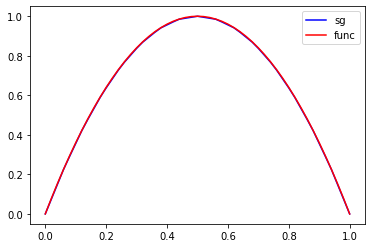

In [26]:
plotSG1d(sg, func)
print("Function interpolation with this sparse grid")